In [15]:
import os
import torch
import torch.nn as nn
import torchmetrics
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

from model import ViT

In [16]:
train_root = Path("Butterfly_Image_Classification_75_species/train")
test_root = Path("Butterfly_Image_Classification_75_species/test")

In [17]:
epochs = 100
batch_size = 128
resized_size = 112

In [18]:
def get_label_dict(*, path:Path):
    labels_list = map(lambda x : x.parts[-1], list(path.iterdir()))
    labels_dict = dict()

    for index, title in enumerate(labels_list):
        labels_dict[title] = index 
    
    return labels_dict

In [19]:
class Butterfly_Dataset(Dataset):
    def __init__(self, root:Path, label_dict:dict, transform=None):
        self.data_pathes = list(root.glob("**/*.jpg"))
        self.label_dict = label_dict
        self.transform = transform

    def __len__(self):
        return len(self.data_pathes)

    def __getitem__(self, idx):
        path = self.data_pathes[idx]
        image = Image.open(path)
        if self.transform:
            image = self.transform(image)
        label = self.label_dict[str(path.parts[-2])]

        return image, label

In [20]:
label_dict = get_label_dict(path=train_root)

In [21]:
print(list(label_dict.keys())[:5])
print(list(label_dict.values())[:5])

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO']
[0, 1, 2, 3, 4]


In [22]:
train_transform = T.Compose(
    [
        T.RandomHorizontalFlip(p=.5),
        T.RandomVerticalFlip(p=.5),
        T.RandomApply(
            transforms=[
                # T.RandomResizedCrop(resized_size),
                T.RandomRotation(30),
                T.ColorJitter(
                    brightness=.3,
                    # contrast=.2,
                    # saturation=.6,
                    hue=.2
                ),
            ],
            p=.3
        ),
        T.Resize(size=(resized_size,resized_size)),        
        T.ToTensor()
    ]
)

test_transform = T.Compose(
    [
        T.Resize(size=(resized_size,resized_size)),
        T.ToTensor()
    ]
)

In [23]:
train_dataset = Butterfly_Dataset(root=train_root, label_dict=label_dict, transform=train_transform)
test_dataset = Butterfly_Dataset(root=test_root, label_dict=label_dict, transform=test_transform)

num_worker = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_worker)

torch.Size([3, 112, 112])


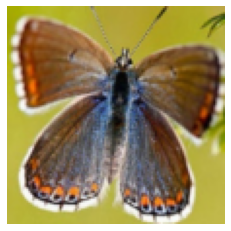

In [24]:
img, label = train_dataset[0]
# img = T.RandomCrop(112)(img)
# img = T.RandomResizedCrop(size=(112, 112))(img)
print(img.shape)
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.axis("off");


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:
model = ViT(
    in_channels=3, 
    patch_size=16, 
    linear_Embed_size=128, 
    num_tr_encoders=4,
    num_msa_heads=2, 
    mlp_ratio=4,
    out_features=75 # MNIST classification
)

In [27]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
accuracy = torchmetrics.Accuracy().to(device)

In [28]:
pbar = tqdm(range(epochs))

metrics = dict(
    train_losses=[],
    test_losses=[],
    train_accs=[],
    test_accs=[]
)

for epoch in pbar:

    loss_batch_train = 0
    accuracy_batch_train = 0
    loss_batch_test = 0
    accuracy_batch_test = 0
    
    model.train()
    for i, (img, lbl) in enumerate(train_dataloader):
        img = img.to(device)
        lbl = lbl.to(device)

        preds = model(img)
        loss = criterion(preds, lbl)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_batch_train += loss.detach().cpu().item()
        accuracy_batch_train += accuracy(preds, lbl).detach().cpu().item()

        pbar.set_postfix(
            {
                "epoch":f"{(epoch+1):02d}",
                "mode":"train",
                "index":f"{(i+1):03d}",
                "train_loss":f"{loss_batch_train/(i+1):.3f}",
                "train_accuracy":f"{accuracy_batch_train/(i+1):.3f}",
                "test_loss":f"{metrics['test_losses'][-1] if len(metrics['test_losses'])>0 else np.Infinity :.3f}",
                "test_accuracy":f"{metrics['test_accs'][-1] if len(metrics['test_accs'])>0 else 0:.3f}"
            }
        )
        

    metrics['train_losses'].append(loss_batch_train/(i+1))
    metrics['train_accs'].append(accuracy_batch_train/(i+1))
    
    
    model.eval()
    for i, (img, lbl) in enumerate(test_dataloader):
        img = img.to(device)
        lbl = lbl.to(device)

        with torch.inference_mode():
            preds = model(img)
            loss = criterion(preds, lbl)
        
        loss_batch_test += loss.detach().cpu().item()
        accuracy_batch_test += accuracy(preds, lbl).detach().cpu().item()
        
        pbar.set_postfix(
            {
                "epoch":f"{(epoch+1):02d}",
                "mode":"test",
                "index":f"{(i+1):03d}",
                "train_loss":f"{metrics['train_losses'][-1]:.3f}",
                "train_accuracy":f"{metrics['train_accs'][-1]:.3f}",
                "test_loss":f"{loss_batch_test/(i+1):.3f}",
                "test_accuracy":f"{accuracy_batch_test/(i+1):.3f}"
            }
        )

    metrics['test_losses'].append(loss_batch_test/(i+1))
    metrics['test_accs'].append(accuracy_batch_test/(i+1))
        

100%|██████████| 100/100 [30:00<00:00, 18.01s/it, epoch=100, mode=test, index=003, train_loss=4.013, train_accuracy=0.332, test_loss=4.048, test_accuracy=0.287]


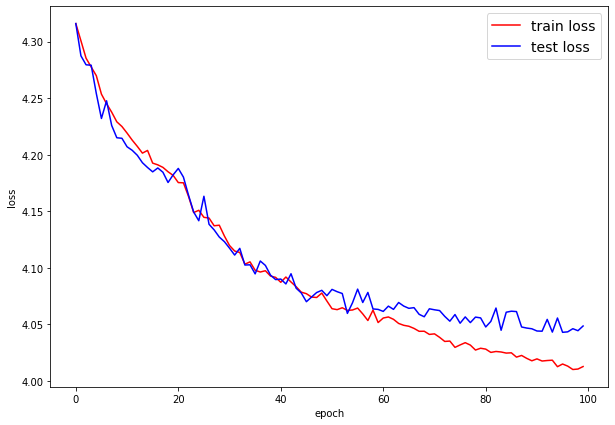

In [29]:
plt.figure(figsize=(10,7))
plt.plot(metrics['train_losses'], c='r', label="train loss")
plt.plot(metrics['test_losses'], c='b', label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(prop={"size":14});

In [30]:
import random

In [52]:
rnd = random.randint(a=0, b=len(test_dataset))
img, lbl = test_dataset[rnd]

BROWN SIPROETA 12


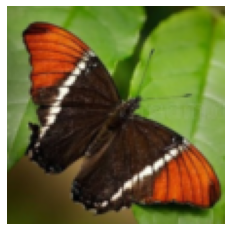

In [53]:
label_title = list(label_dict.keys())[lbl]
print(label_title, lbl)
plt.imshow(img.permute((1,2,0)))
plt.axis("off");

In [54]:
device

device(type='cuda')

In [55]:
model.eval()
with torch.inference_mode():
    img = img.to(device)
    img = img.unsqueeze(dim=0)
    preds = model(img)

In [56]:
predicted_class = torch.argmax(preds).detach().cpu().item()

In [57]:
predicted_class, list(label_dict.keys())[predicted_class]

(43, 'MOURNING CLOAK')

In [58]:
lbl, list(label_dict.keys())[lbl]

(12, 'BROWN SIPROETA')